# "Let's Make a Deal!"
> "Monty Hall meets Monte Carlo"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [probability, simulation, monte-carlo, monty-hall, counterintuitive]
- hide: false
- image: images/three_doors.jpg
- search_exclude: false
- metadata_key1: simulation
- metadata_key2: probability

# The Monty Hall Problem

The Monty Hall problem has probably achieved cultural saturation at this point, but we'll start with a quick refresher:

You are playing a game show in which you are shown three numbered doors (1, 2, 3). One of the doors has a prize behind it; the other two do not. You choose a door -- let's say door 1, though it doesn't really matter -- after which the host (Monty Hall) opens door 3 to reveal that it does *not* have the prize. He then offers you the opportunity to switch from door 1, which you chose, to door 2, the only other remaining door. Should you take his offer to switch? (Does it even matter?)

We should stipulate for the record that we mean the traditional collection of "Monty Hall" rules: that is, Monty will always open one door, he *does* know where the prize is, and he will never reveal a door that has the prize behind it. If you have chosen the prize correctly on the first guess, then he will flip a coin to decide which of the other doors to reveal.

## The Incorrect Answer

I was first exposed to this problem in college when a friend posed the question to me as a brain teaser to at a cafeteria table. I gave the only sensible answer, which was to say that since you had two doors, **getting the prize was a 50/50 proposition no matter what you chose**. I was, of course, dead wrong.

For years, I was slightly embarrassed about this. Not *too* embarrassed, mind you -- after all, I'm wrong all the time. But this one stung because my friend was on my home turf; at this point in my life, I was pretty sure I was going to try to pursue a PhD in Mathematics and I suspected I might gravitate to the field of Probability Theory. Just like that, I whiffed on a probability question in a semi-public forum. 

My shame was lessened over the years when I learned that if nothing else, I wasn't alone. When Marilyn Vos Savant gave a correct solution to the problem in a 1990 issue of *Parade*, she received [a truckload of letters](https://web.archive.org/web/20130121183432/http://marilynvossavant.com/game-show-problem/), many from professional mathematicians, telling her how wrong she was. (She wasn't wrong, which certainly didn't help the outrageous rudeness of some of those letters.) In his book [Which Door Has the Cadillac: Adventures of a Real Life Mathematician](https://www.maa.org/press/maa-reviews/which-door-has-the-cadillac-adventures-of-a-real-life-mathematician), Andrew Vazsonyi recalls giving the same incorrect "obvious" answer to the problem on his first encounter; perhaps more shockingly, he details an account of discussing the problem with Paul Erdös, who also got the problem wrong and became increasingly irate about it until he was eventually shown a simulation proving what the right answer should be.

## The Correct Answer

That right answer is that **switching is better**. Indeed, staying with your original choice will grant you a $1/3$ chance of winning, and switching will grant a $2/3$ chance of winning. The key detail, of course, is Monty's knowledge of the problem and choice of exactly *how* to reveal what he knows. There are many ways to see why this is true; the [Wikipedia entry](https://en.wikipedia.org/wiki/Monty_Hall_problem) for the Monty Hall problem gives many different explanations of many different flavors (and even criticisms of those same explanations). These explanations are great, but to those who aren't accustomed to long mathematical arguments, they might be less than convincing. 

The first explanation of the solution in the Wikipedia article states:

> When the player first makes their choice, there is a $2/3$ chance that the car is behind one of the doors not chosen. This probability does not change after the host reveals a goat behind one of the unchosen doors.

This explanation never quite sat right with me. As Sasha Volokh [put it](https://www.washingtonpost.com/news/volokh-conspiracy/wp/2015/03/02/an-easy-answer-to-the-infamous-monty-hall-problem/): 

> First, it’s clear that any explanation that says something like “the probability of door 1 was 1/3, and nothing can change that...” is automatically fishy: probabilities are expressions of our ignorance about the world, and new information can change the extent of our ignorance.

This is where simulations can do some good.

## Simulations

We'll write Monte Carlo simulations in R to see that by sticking with our original answer, the probability of winning is indeed $1/3$. We will write a function that simulates one full round of the game; then, we'll `replicate()` the function many times to determine the probability of winning. Our strategy will be to simulate a round of the full game many times and keep track of how often the game results in a win.

For our first attempt, we'll recreate a very general version of the game:
  * the prize can be found behind any of 3 doors
  * the contestant will pick any of 3 doors
  * Monty will reveal one door and offer a chance to switch
  * the contestant will choose to switch or stay depending on the parameter `stay`

In [33]:
#collapse_output

library(ggplot2)
library(dplyr)
library(tidyr)
options(repr.plot.width=10, repr.plot.height=6)

monty_hall <- function(stay){
    
  doors <- c("A", "B", "C")              # using ABC instead of 123 due to a quirk in sample()

  prize_door <- sample(doors, 1)
  contestant_choice <- sample(doors, 1)
    
  reveal_door <-                                # Monty can't reveal the door with the prize,
    union(prize_door, contestant_choice) %>%    # nor can he reveal the selected door, so we'll
    setdiff(doors, .) %>%                       # remove those choices from the doors vector
    sample(1)  

  switch_offer <- setdiff(doors, c(contestant_choice, reveal_door))
    
  ifelse(prize_door == ifelse(stay, contestant_choice, switch_offer), "win", "lose")
    # the function returns the strings "win" and "lose"
    # when stay is TRUE, check to see if the prize door matches the contestant's choice
    # when stay is FALSE, check to see if the prize door matches the door offered in a switch
}

Next, we'll generate 10K trials of the game under each of the two options (switching and staying). We'll reshape the outcomes just a bit and then plot them.

In [12]:
monty_stay_trials <- replicate(10000, monty_hall(stay = TRUE))
monty_switch_trials <- replicate(10000, monty_hall(stay = FALSE))

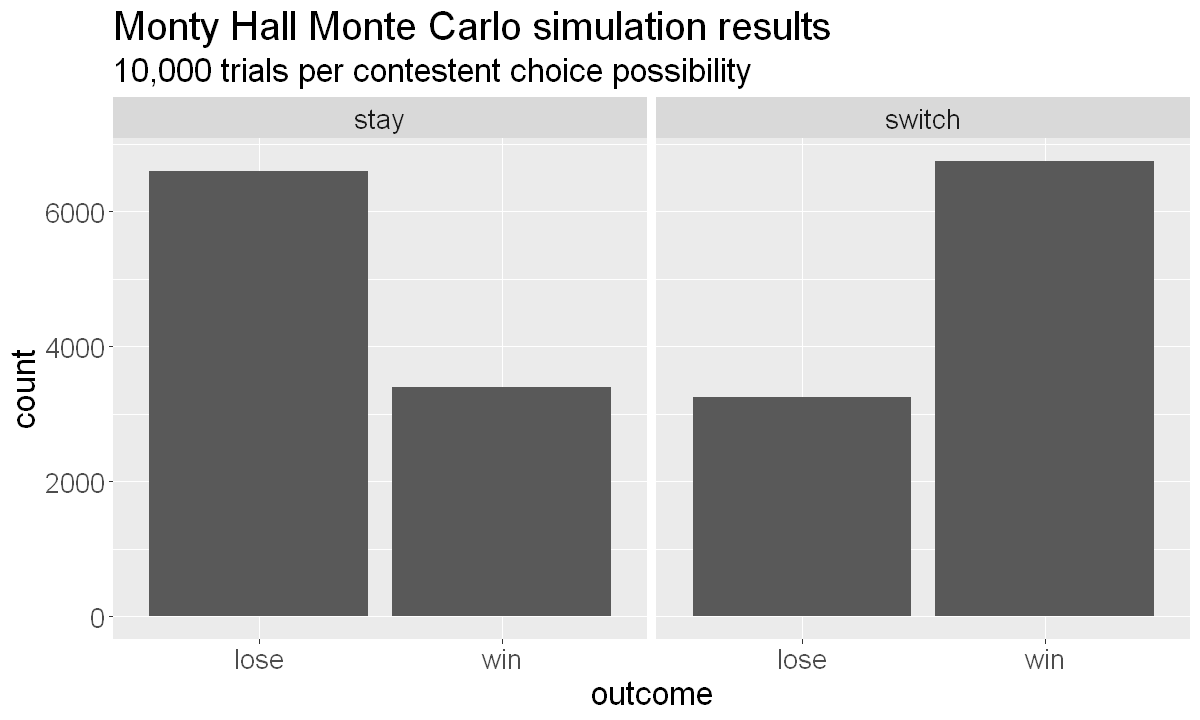

In [31]:
data.frame(stay = monty_stay_trials, switch = monty_switch_trials) %>%
  pivot_longer(everything(), names_to = "choice", values_to = "outcome") %>% 
  ggplot(aes(x = outcome)) +
    geom_bar(stat = "count") +
    facet_wrap(~choice) +
    labs(title = "Monty Hall Monte Carlo simulation results",
         subtitle = "10,000 trials per contestent choice possibility") +
    theme(text = element_text(size = 20))

The simulations show us exactly what we expected; switching is good, staying is bad. We can also easily confirm that the probability of winning by switching is $2/3$:

In [32]:
mean(monty_switch_trials == "win")

[1] 0.6747

Our answer is close to $2/3$, and the difference between it and $2/3$ is a small statistical fluctuation, as expected.

So, good news: we have confirmed that the correct answer is indeed correct. But can we render any deeper insights from this? Let's focus on the function in the case when `stay == TRUE`. In that case, the code looks like this:

```
monty_hall <- function(stay){
    
  doors <- c("A", "B", "C")      

  prize_door <- sample(doors, 1)
  contestant_choice <- sample(doors, 1)
    
  reveal_door <- 
    union(prize_door, contestant_choice) %>%    
    setdiff(doors, .) %>%                       
    sample(1)  

  switch_offer <- setdiff(doors, c(contestant_choice, reveal_door))
    
  ifelse(prize_door == contestant_choice, "win", "lose")
}

```

Here, `switch_offer` doesn't actually get used at all in the line that returns the function. This means that the `switch_offer <- ...` line, and the `reveal_door <- ...` lines, are unused appendages. If we remove them, we're left with this:

```
monty_hall <- function(stay){
    
  doors <- c("A", "B", "C")      

  prize_door <- sample(doors, 1)
  contestant_choice <- sample(doors, 1)
    
  ifelse(prize_door == contestant_choice, "win", "lose")
}
```

Now, we see that our code has reduced to a simulation that draws two objects independently from a collection of three and checks to see if they're the same. That probability is clearly $1/3$, and this explanation now aligns perfectly with the Wikipedia explanation that nothing has changed the original probability of $1/3$, whether that explanation is "fishy" or not.

## Takeaway

It's great to be able to use Monte Carlo simulations to confirm a correct answer, but in this case the act of writing a simulation can do something more profound: it can make the *why* behind the answer just a bit more convincing. Or, at least, it did that for me. I've seen (and believed, and produced) many analytical arguments for why switching has a $2/3$ probability, but I never fully believed the Wikipedia explanation until writing code to simulate the game.